In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape, Dropout, LeakyReLU, BatchNormalization, Activation, UpSampling2D, Conv2DTranspose,Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Build Discriminator
def build_discriminator():
    model = Sequential([
        Conv2D(input_shape=(28, 28, 1), filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.4),
        Conv2D(filters=64, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.4),
        Conv2D(filters=128, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.4),
        Conv2D(filters=256, kernel_size=(5, 5), strides=(2, 2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.4),
        Flatten(),
        Dense(units=1, activation="sigmoid")
    ])
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Build Generator
def build_generator():
    model = Sequential([
        Input(shape=(100,)),
        Dense(units=7 * 7 * 192),
        BatchNormalization(),
        Activation("relu"),
        Reshape(target_shape=(7, 7, 192)),
        Dropout(0.4),
        UpSampling2D(size = (2,2)),
        Conv2DTranspose(filters=96, kernel_size=(5, 5), strides= 1, padding='same'),
        BatchNormalization(),
        Activation("relu"),
        UpSampling2D(size = (2,2)),
        Conv2DTranspose(filters=48, kernel_size=(5, 5), strides=1, padding='same'),
        BatchNormalization(),
        Activation("relu"),
        Conv2DTranspose(filters=24, kernel_size=(5, 5), strides=1, padding='same'),
        BatchNormalization(),
        Activation("relu"),
        Conv2DTranspose(filters=1, kernel_size=(5, 5), strides=1 , padding='same', activation="sigmoid")
    ])
    return model

# Build GAN
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = Sequential([generator, discriminator])
    model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss="binary_crossentropy")
    return model

# Load and preprocess MNIST dataset
def load_and_preprocess_data():
    (x_train, _), (_, _) = mnist.load_data()
    x_train = x_train / 255.0  # Normalize to [0, 1]
    x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
    return x_train


# Plot and save loss curves
def plot_loss(d_losses, g_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(d_losses, label="Discriminator Loss")
    plt.plot(g_losses, label="Generator Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.savefig("loss_curve.png")
    plt.close()

# Save generated images

def save_generated_images(generator,epoch):
        
    num_images = 16  # Number of images to generate
    noise_dim = 100  # Dimension of the latent space
    noise = np.random.normal(0, 1, (num_images, noise_dim))

    # Generate images
    generated_images = generator.predict(noise)

    generated_images = (generated_images + 1) / 2.0

    # Save the generated images
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f"generated_images_epoch_{epoch}.png")
    plt.show()

# Train GAN
def train_gan(generator, discriminator, gan, epochs, batch_size):
    X_train = load_and_preprocess_data()
    
    # Labels for real (1) and fake (0)
    real_label = np.ones((batch_size, 1))
    fake_label = np.zeros((batch_size, 1))

    # Initialize lists to record losses
    d_losses = []
    g_losses = []

    for epoch in range(epochs):
        # ---------------------
        # Train Discriminator
        # ---------------------
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = X_train[idx]

        noise = np.random.normal(0, 1, (128, 100))
        fake_images = generator.predict(noise)

        d_loss_real = discriminator.train_on_batch(real_images, real_label)
        d_loss_fake = discriminator.train_on_batch(fake_images, fake_label)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        # Train Generator
        # ---------------------
        noise = np.random.normal(0, 1, (batch_size, 100))
        g_loss = gan.train_on_batch(noise, real_label)

        # Losses at the end of the epoch
        d_losses.append(d_loss[0])
        g_losses.append(g_loss)
        
        # Save generated images at specific epochs
        if epoch + 1 in [1, 500, 1000, 1500,2000,2500,3000]:
            save_generated_images(generator, epoch + 1)


    # Plot and save loss curves after training
    plot_loss(d_losses, g_losses)

# Build and train GAN
generator = build_generator()
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

train_gan(generator, discriminator, gan, epochs=3000, batch_size=128)


4/4 [==============================] - 0s 98ms/step


1/1 [==============================] - 0s 150ms/step


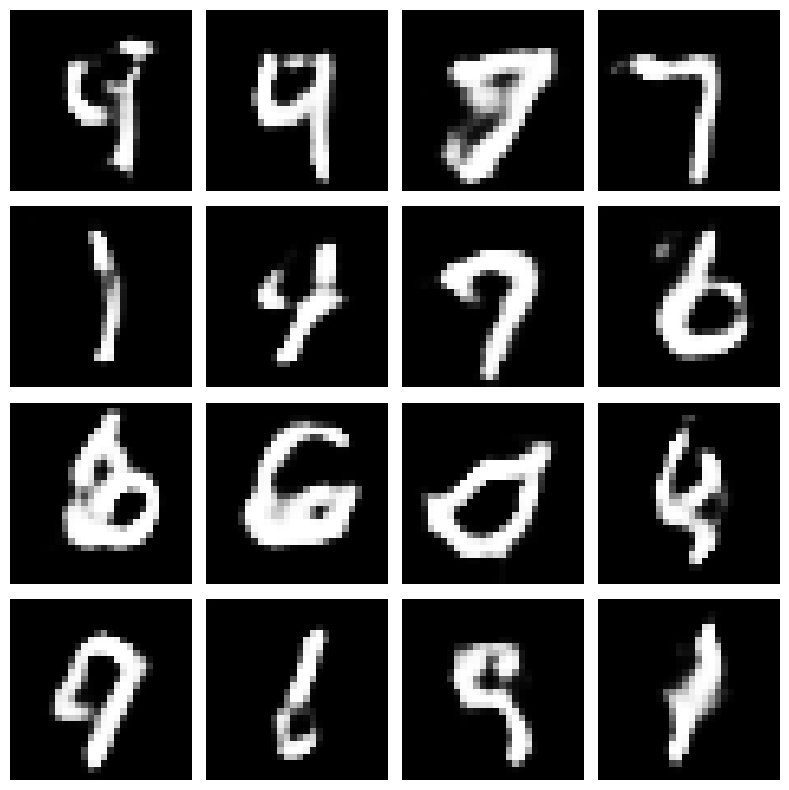

In [12]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the saved generator model
generator = tf.keras.models.load_model('saved_models/generator_epoch_3000.h5')
def save_generated_images(generator,epoch):
        
    # Generate random noise
    num_images = 16  # Number of images to generate
    noise_dim = 100  # Dimension of the latent space
    noise = np.random.normal(0, 1, (num_images, noise_dim))

    # Generate images
    generated_images = generator.predict(noise)

    # Rescale pixel values from [-1, 1] to [0, 1] if needed
    generated_images = (generated_images + 1) / 2.0

# Plot the generated images
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('1.png')  # Save images to file
    plt.show()
save_generated_images(generator,1)
